In [ ]:
%pip install myqlm

# Revisão de Estimativa de Fase

In [ ]:
from qat.lang import *
from qat.qpus import PyLinalg
import numpy as np
from qat.lang.AQASM.qftarith import QFT

pi = np.pi

In [ ]:
# construindo matriz U personalizada
def gerador_da_matriz():
  eigvals = [np.exp(1j*theta) for theta in [0, pi/8, 2*pi/8, 3.5*pi/8]]
  U = np.diag(eigvals)
  return U

In [ ]:
from qat.lang.AQASM.gates import ParamGate

# construindo porta para matriz U
abstract_U = AbstractGate("Porta U", [],
                          matrix_generator=gerador_da_matriz)
# é possível criar uma porta parametrizada personalizada

porta_U = ParamGate(abstract_U, 2) # (AbstractGate, arity)

# exibindo circuito
rotina_U = QRoutine()
fios = rotina_U.new_wires(porta_U.arity)
rotina_U.apply(porta_U, fios)

In [ ]:
# construindo circuito de potências controladas
def potencia_controlada(porta, p):
  # p é a qtd de qubits no primeiro registrador
  pot_ctrl = QRoutine()
  fios = pot_ctrl.new_wires(p + porta.arity)

  for i in range(p):
    for j in range(2**i):
      pot_ctrl.apply(porta.ctrl(), p - 1 - i, list(range(p, p + porta.arity)))

  return pot_ctrl

In [ ]:
# Construindo rotina final da estimativa de fase

def estimativa_de_fase(porta, p):
  # p é o número de bits de precisão na estimativa (qubits no primeiro registrador)
  est_fase = QRoutine()
  pot_ctrl = potencia_controlada(porta, p)
  fios = est_fase.new_wires(pot_ctrl.arity)

  # aplicar a transformada de Fourier no primeiro registrador
  for i in range(p):
    est_fase.apply(H, i)

  # potencia controlada
  est_fase.apply(pot_ctrl, fios)

  # aplicar a transformada de Fourier inversa no segundo registrador
  for i in range(0, p // 2):
    est_fase.apply(SWAP, i, p - 1 - i)
  est_fase.apply(QFT(p).dag(), fios[:p])

  return est_fase

In [ ]:
import matplotlib.pyplot as plt

# plota a distribuição de probabilidade dos estados do primeiro registrador
# dado que a entrada do segundo registrador foi um autovetor
def plot_probs(results, p):
  labels = [bin(i)[2:].rjust(p, '0') for i in range(2**p)]
  probs = [0] * 2**p
  for sample in results:
    probs[int(str(sample.state)[1:p+1], 2)] = sample.probability

  plt.xticks(rotation=60)
  plt.xlabel("Estado")
  plt.ylabel("Probabilidade")
  plt.bar(labels, probs)
  plt.show()

Entrada: |000000>


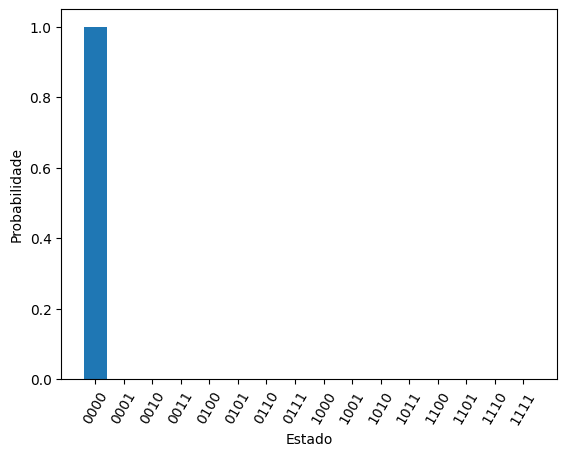

-----------------------------------
Entrada: |000001>


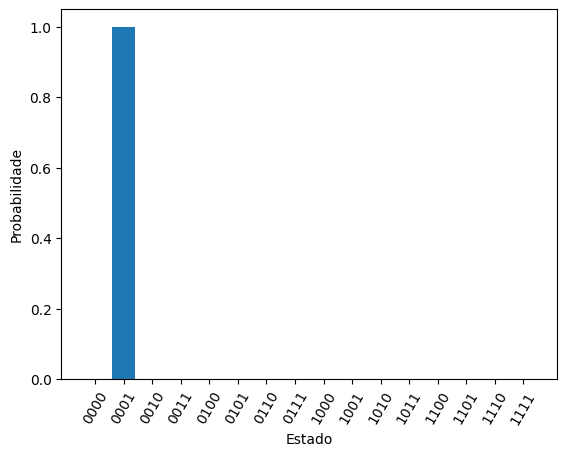

-----------------------------------
Entrada: |000010>


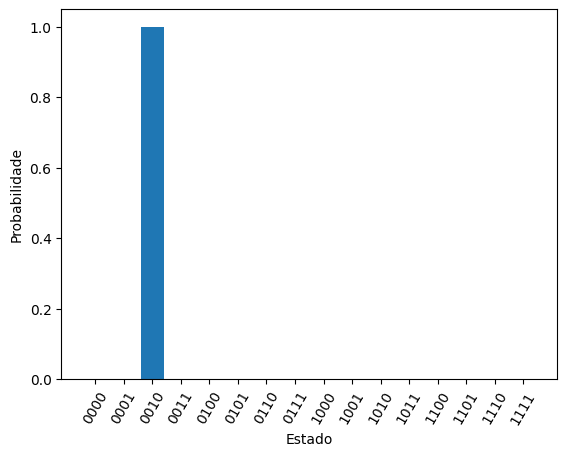

-----------------------------------
Entrada: |000011>


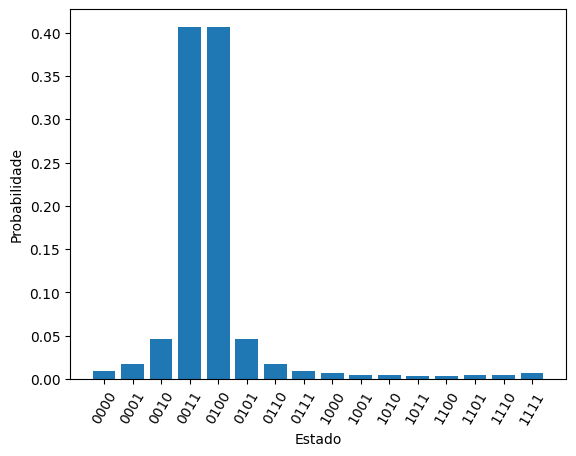

-----------------------------------


In [ ]:
# Simulando estimativa de fase para 4 autovetores

# Create a Quantum Processor Unit
linalgqpu = PyLinalg()

p = 4
rotina_est_fase = estimativa_de_fase(porta_U, p)

for entrada in range(2**porta_U.arity):

  prog = Program()
  qr = prog.qalloc(rotina_est_fase.arity)

  # manipulação de strings para mostrar toda a entrada
  entrada = bin(entrada)[2:].rjust(porta_U.arity, '0')
  print("Entrada: |" + '0'*p + str(entrada) + ">")

  # mudando a entrada do segundo registrador
  for i in range(porta_U.arity):
    if entrada[i] == '1':
      prog.apply(X, qr[-porta_U.arity + i])

  prog.apply(rotina_est_fase, qr)

  job = prog.to_circ().to_job()
  result = linalgqpu.submit(job)
  plot_probs(result, p)

  print('-----------------------------------')

Relembrando circuito de potências controladas.

In [ ]:
potencia_controlada(rotina_U, 3).display()

Relembrando o circuito de estimativa de fase

In [ ]:
estimativa_de_fase(rotina_U, 3).display()

# Algoritmo de Shor

## Problema

Dado um número $N$ não primo, deseja-se encontrar todos os fatores primos de $N$. Seja $N = n_1 n_2$ onde $1 < n_1, n_2 < N$ são números naturais. Se for possível encontrar um fator primo (e.g. $n_1$) de modo eficiente, então é possível encontrar os fatores primos de $n_2 = N/n_1$ de modo eficiente. Logo, encontrando a decomposiçaõ de $N$ em fatores primos.

A ordem multiplicativa $r$ de um numéro $a$ módulo $N$ é o menor inteiro positivo tal que

\begin{align}
  a^r \equiv 1 \text{ mod } N.
\end{align}

Por exemplo, para $a = 2$ e $N = 21$, temos

In [ ]:
a = 2
N = 21
r = -1
for i in range(1, 21):
  res = np.power(a, i) % N
  print("2^" + str(i) + " = " + str(res) + " mod " + str(N))
  if r < 0 and res == 1:
    r = i

print()
print("A ordem multiplicativa eh: " + str(r))

2^1 = 2 mod 21
2^2 = 4 mod 21
2^3 = 8 mod 21
2^4 = 16 mod 21
2^5 = 11 mod 21
2^6 = 1 mod 21
2^7 = 2 mod 21
2^8 = 4 mod 21
2^9 = 8 mod 21
2^10 = 16 mod 21
2^11 = 11 mod 21
2^12 = 1 mod 21
2^13 = 2 mod 21
2^14 = 4 mod 21
2^15 = 8 mod 21
2^16 = 16 mod 21
2^17 = 11 mod 21
2^18 = 1 mod 21
2^19 = 2 mod 21
2^20 = 4 mod 21

A ordem multiplicativa eh: 6


logo, $r$ = 6.

Se $r$ for par, então
\begin{align}
  (a^{r/2} + 1)(a^{r/2} - 1)
  = a^r - 1 = 0 \text{ mod } N.
\end{align}
Se $a^{r/2} \pm 1 \notin \{0, kN\}$ para $k$ inteiro, então
$a^{r/2} \pm 1$ têm fatores que multiplicados resultam em $N$.
Então, $mdc(a^{r/2} \pm 1, N) > 1$ é um fator (não necessariamente primo) de $N$.
Nota: o algoritmo para calcular o $mdc$ é eficiente.
Continuando o exemplo,

In [ ]:
# calcular dois números
from math import gcd as mdc
print("a = " + str(a))
print("N = " + str(N))
print("r = " + str(r))

num_1 = int(np.power(a, r/2) + 1)
num_2 = int(np.power(a, r/2) - 1)
print("num_1 = " + str(num_1))
print("mdc(" + str(num_1) + ", " + str(N) + ") = " + str(mdc(num_1, N)))
print("num_2 = " + str(num_2))
print("mdc(" + str(num_2) + ", " + str(N) + ") = " + str(mdc(num_2, N)))

a = 2
N = 21
r = 6
num_1 = 9
mdc(9, 21) = 3
num_2 = 7
mdc(7, 21) = 7


Parte do algoritmo quântico vai ser calcular todas as exponenciais $a^\ell \mod N$ possível e tentar obter um valor de $\ell$ nos possibilite obter a ordem multiplicativa $r$.
O comportamento to circuito é bem parecido com uma série de potência controladas:

$\newcommand{\ket}[1]{\left| #1 \right\rangle}$
$\newcommand{\bra}[1]{\langle #1 \right|}$
$\newcommand{\im}[0]{\text{i}}$

\begin{align}
  U_{a, N} \ket\ell \ket y = \ket\ell \ket{y \oplus a^\ell \mod N}.
\end{align}
O primeiro registrador tem $p$ qubits onde $p$ é o menor inteiro que satisfaz $P = 2^p > N^2$.
O segundo registrador tem $q = \lceil \log_2 N \rceil$ qubits,
i.e. a quantidade de qubits necessária para representar $N$.

No nosso caso, não nos preocuparemos com o símbolo $\oplus$ pois teremos $y = 0$ o que simplifica o comportamento do circuito para
\begin{align}
  U_{a, N} \ket\ell \ket 0 = \ket\ell \ket{a^\ell \mod N}.
\end{align}

Não nos preocuparemos com a implementação de $U_{a, N}$. Ao invés disso, usaremos a implementação pronta do `myqlm`.

In [ ]:
# função para calcular p
def calcular_p(N):
  P = np.power(N, 2)
  p = int(np.log2(P)) + 1
  return p

print("N = " + str(N))
p = calcular_p(N)
print("p = " + str(p))
q = int(np.ceil(np.log2(N)))
print("q = " + str(q))

N = 21
p = 9
q = 5


In [ ]:
# modular exp
from qat.lang.AQASM.arithmetic import modular_exp

# parâmetros: tamanho do primeiro registrador, tamanho de segundo registrador,
#             base da exponenciação, e módulo
modular_exp(p, q, a, N).display()

Agora vamos usar `modular_exp` para construir o circuito da parte quântica análogo à estimativa de fase.

In [ ]:
# parte quântica
from qat.qpus import get_default_qpu
import qat.lang.AQASM.qftarith as qftarith

def parte_quantica(a, N):
  a = int(a)
  N = int(N)

  shor = Program()
  p = calcular_p(N)
  q = int(np.ceil(np.log2(N)))
  qr1 = shor.qalloc(p)
  qr2 = shor.qalloc(q)

  # Transformada fourier
  for i in range(qr1.length):
    shor.apply(H, i)

  modular_exp(qr1.length, qr2.length, a, N)(qr1, qr2)
  QFT(p).dag()(qr1)

  ##########################
  # The linking process simply attach to each abstract gate a
  # circuit implementation using the function specified at
  # definition of the abstract gate.
  #
  # link (list) – a list of AbstractGate, GateSet, or
  # python packages to pass to the linker.
  circuit = shor.to_circ(link=[qftarith])
  job = circuit.to_job(qubits=qr1, nbshots=100)
  result = get_default_qpu().submit(job)


  eles = [sample for sample in result]
  # amostras estao ordenadas pelo estado |000>, |001>, ...
  # codigo ordena os resultados obtidos pela probabilidade
  eles.sort(key=lambda sample : sample.probability, reverse=True)
  eles = [sample.state.int for sample in eles]

  return eles

In [ ]:
# resultado parte quantica
eles = parte_quantica(a, N)
print(eles)
for l in eles:
  print(a**l % N)

[256, 171, 0, 427, 85, 341, 86, 170, 340, 342, 426, 80, 333, 337, 338, 339, 424, 430, 433]
16
8
1
2
2
11
4
4
16
1
1
4
8
2
4
8
16
16
2


A saída do algoritomo é um número $\ell$ que, com alta probabilidade, satisfaz $\ell = kP/r$ para algum $k$ natural. Como $P$ é conhecido, podemos calcular $k/r = \ell/P$.

In [ ]:
# espera-se múltiplo de 1/r
P = 2**p
print("Esperando multiplo de " + str(1/r))
for l in eles:
  print( (l/P) / (1/r) )

Esperando multiplo de 0.16666666666666666
3.0
2.00390625
0.0
5.00390625
0.99609375
3.99609375
1.0078125
1.9921875
3.984375
4.0078125
4.9921875
0.9375
3.90234375
3.94921875
3.9609375
3.97265625
4.96875
5.0390625
5.07421875


Dessa forma, desejamos extrair, de alguma forma, o denominador $r$ da fração $k/r$. Isso é possível de ser feito utilizando expansão continuada de frações,
\begin{align}
  b = \frac{1}{b_1 + \frac{1}{b_2 + \frac{1}{\ddots + \frac{1}{b_z}}}},
\end{align}
onde $b$ é racional e $0 < b < 1$ e todo $b_i$ é natural.
Nosso objetivo é encontrar o convergente $[b_1, \ldots, b_j]$ com o maior valor de $j$ onde o denominador da fração correspondente seja menor que $N$.

Calculando os convergentes para $\ell = 85$:

In [ ]:
l = 85
print(l/P)

conv = []
# ilustrar processo para calcular o convergente
# inverter e selecionar parte inteira
num = P
den = l
conv.append(num // den)
print("Parte inteira: " + str(conv[0]))

# salvar fração restante
novo_num = num - conv[0]*den
novo_den = den
print("Resta :" + str(novo_num / novo_den))

# repetir esse processo...
num = novo_den
den = novo_num
conv.append(num // den)
print("conv: " + str(conv))

0.166015625
Parte inteira: 6
Resta :0.023529411764705882
conv: [6, 42]


Como calcular a fração correspondente ao convergente [6, 42]?

\begin{align}
  \frac{1}{6 + \frac{1}{42}} = \frac{1}{\frac{6 \cdot 42 + 1}{42}}
  = \frac{42}{6 \cdot 42 + 1} .
\end{align}
e o denominador de interesse nesse caso seria $6 \cdot 42 + 1$ desde que seja o maior denominador menor que $N$.
No caso do nosso exemplo, $N = 21$, então temos que selecionar convergente anterior $[6]$, cujo denominador é 6.

In [ ]:
# função para calcular a aproximação dada pelo convergente
def aproximacao_de_fracao(conv):
  num = 1
  den = conv[-1]
  # print(conv)
  for i in range(2, len(conv) + 1):
    temp = den
    den = conv[-i] * den + num
    num = temp

  return (num, den)

print(aproximacao_de_fracao([6]))
print(aproximacao_de_fracao([6, 42]))

(1, 6)
(42, 253)


Antes de prosseguir, vamos construir a função que encontra o candidato a $r$ utilizando os convergentes .

In [ ]:
# encontrar_r
def encontrar_r(numerador, denominador, N):
  conv = []
  # pula a primeira iteracao supondo que parte inteira seja = 0
  temp = numerador
  numerador = denominador
  denominador = temp

  r = 0

  while(True):
    b_i = numerador // denominador
    conv.append(b_i)

    temp = numerador - b_i*denominador
    numerador = denominador
    denominador = temp

    num_aprox, den_aprox = aproximacao_de_fracao(conv)
    # print(num_aprox, den_aprox)

    if (denominador == 0 and den_aprox < N):
      return den_aprox

    if  (den_aprox >= N):
      return r

    r = den_aprox

  return r

In [ ]:
# executar
encontrar_r(l, P, N)

6

Com o candidato a $r$ em mãos, precisamos verificar se ele satisfaz as propriedades necessárias.
Primeiramente, a gente deseja que $r$ seja par para poder calcular
$(a^{r/2} + 1)(a^{r/2} - 1)$.
Se esse for o caso, calculamos $n_1 = mdc((a^{r/2} + 1), N)$.
Se $n_1$ for primo então ele é um fator de $N$ e executamos o algoritmo novamente para $N/n_1$.
Caso contrário, executamos o algoritmo de Shor para $n_1$ e $N/n_1$.

In [ ]:
def primo(num):
    if num < 2:
      return False

    for x in range(2, int(np.sqrt(num)) + 1):
      if num % x == 0:
        return False

    return True

Por último, resta definir como obter $1 < a < N$.
Isso pode ser feito de modo aleatório.
E como o algoritmo de $mdc$ é eficiente,
podemos verificar previamente se $mdc(a, N) > 1$ antes de
invocar a parte quântica do algoritmo.

Juntando tudo, construímos a parte clássica do algoritmo.

In [ ]:
# algoritmo clássico
import random

def parte_classica(N):
  fatores = []
  novas_amostras = True

  while (N != 1):
    print("N = " + str(N))

    if primo(N):
      fatores.append(N)
      break

    if N % 2 == 0:
      fatores.append(2)
      N = N // 2
      novas_amostras = True
      print("fatores " + str(fatores))
      print()
      continue

    if novas_amostras:
      amostras = random.sample( list(np.arange(2, N)), N - 2 )
    a = amostras.pop()
    print("a = " + str(a))

    res_mdc = mdc(a, N)
    print("res_mdc = " + str(res_mdc))
    if res_mdc > 1:
      fatores += parte_classica(res_mdc)
      N = N // res_mdc
      novas_amostras = True
      print("fatores " + str(fatores))
      print()
      continue

    p = calcular_p(N)
    print("p = " + str(p))
    eles = parte_quantica(a, N)
    print("eles = " + str(eles))

    for l in eles:
      if l == 0:
        continue

      r = encontrar_r(l, 2**p, N)
      print("r = " + str(r))

      n1 = mdc(np.power(a, r//2) + 1, N) if r % 2 else N
      if 1 < n1 and n1 < N:
        fatores += parte_classica(n1)
        N = N // n1
        novas_amostras = True
        print("fatores " + str(fatores))
        print()
        break
      else:
        novas_amostras = False

  return fatores


In [ ]:
# executar
parte_classica(21)

N = 21
a = 19
res_mdc = 1
p = 9
eles = [171, 0, 256, 85, 427, 341, 86, 172, 342, 84, 170, 83, 87, 169, 426, 428, 429, 433]
r = 3
r = 2
r = 6
r = 6
r = 3
r = 6
r = 3
r = 3
r = 6
r = 3
r = 6
r = 6
r = 3
r = 6
r = 6
r = 6
r = 13
N = 21
a = 6
res_mdc = 3
N = 3
fatores [3]

N = 7


[3, 7]

In [ ]:
parte_classica(27)

N = 27
a = 3
res_mdc = 3
N = 3
fatores [3]

N = 9
a = 4
res_mdc = 1
p = 7
eles = [0, 43, 85, 86, 42, 44, 29, 45, 60, 62, 83, 87]
r = 3
r = 3
r = 3
r = 3
r = 3
r = 4
r = 3
r = 2
r = 2
r = 3
r = 3
N = 9
a = 6
res_mdc = 3
N = 3
fatores [3, 3]

N = 3


[3, 3, 3]